In [1]:
## Full Pipeline: Max Features + Recency + Aggregates with Tuning, Ensemble, SHAP
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from pybaseball import batting_stats
import matplotlib.pyplot as plt
from tqdm import tqdm
import shap
import warnings
warnings.filterwarnings('ignore')


/Users/ak11/Desktop/Miscellaneous/Projects/baseball/mlb-performance-predictor/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
feature_cols = ['G', 'AB', 'PA', 'H', '1B', '2B', '3B', 'HR', 'R', 'RBI', 'BB', 'IBB', 'SO', 'HBP', 'SF', 'SB', 'CS',
    'AVG', 'OBP', 'SLG', 'OPS', 'ISO', 'BABIP', 'BB%', 'K%', 'BB/K', 'wOBA', 'wRC', 'wRC+', 'WAR', 'HR/FB',
    'LD%', 'GB%', 'FB%', 'Pull%', 'Cent%', 'Oppo%', 'Soft%', 'Med%', 'Hard%', 'EV', 'LA', 'Barrel%', 'HardHit%',
    'O-Swing%', 'Z-Swing%', 'Swing%', 'O-Contact%', 'Z-Contact%', 'Contact%', 'SwStr%', 'Zone%', 'F-Strike%']


In [3]:
years = {}
for year in range(1900, 2024):
    try:
        df = batting_stats(year)
        df['Season'] = year
        years[year] = df
        print(f"Loaded {year}")
    except Exception as e:
        print(f"Failed to load {year}: {e}")


Loaded 1900
Loaded 1901
Loaded 1902
Loaded 1903
Loaded 1904
Loaded 1905
Loaded 1906
Loaded 1907
Loaded 1908
Loaded 1909
Loaded 1910
Loaded 1911
Loaded 1912
Loaded 1913
Loaded 1914
Loaded 1915
Loaded 1916
Loaded 1917
Loaded 1918
Loaded 1919
Loaded 1920
Loaded 1921
Loaded 1922
Loaded 1923
Loaded 1924
Loaded 1925
Loaded 1926
Loaded 1927
Loaded 1928
Loaded 1929
Loaded 1930
Loaded 1931
Loaded 1932
Loaded 1933
Loaded 1934
Loaded 1935
Loaded 1936
Loaded 1937
Loaded 1938
Loaded 1939
Loaded 1940
Loaded 1941
Loaded 1942
Loaded 1943
Loaded 1944
Loaded 1945
Loaded 1946
Loaded 1947
Loaded 1948
Loaded 1949
Loaded 1950
Loaded 1951
Loaded 1952
Loaded 1953
Loaded 1954
Loaded 1955
Loaded 1956
Loaded 1957
Loaded 1958
Loaded 1959
Loaded 1960
Loaded 1961
Loaded 1962
Loaded 1963
Loaded 1964
Loaded 1965
Loaded 1966
Loaded 1967
Loaded 1968
Loaded 1969
Loaded 1970
Loaded 1971
Loaded 1972
Loaded 1973
Loaded 1974
Loaded 1975
Loaded 1976
Loaded 1977
Loaded 1978
Loaded 1979
Loaded 1980
Loaded 1981
Loaded 1982
Load

In [4]:
player_data = []

for target_year in range(2000, 2024):
    try:
        df_target = years[target_year][['Name', 'OPS']].rename(columns={'OPS': 'OPS_target'})
        df_target['Season'] = target_year

        df_y1 = years.get(target_year - 1)
        if df_y1 is None:
            continue
        y1_features = df_y1[['Name'] + [col for col in feature_cols if col in df_y1.columns]].copy()
        y1_features.columns = [f"{col}_y1" if col != 'Name' else 'Name' for col in y1_features.columns]

        history_years = [years[y] for y in range(1900, target_year - 1) if y in years]
        if not history_years:
            continue
        df_history = pd.concat(history_years)
        valid_cols = [col for col in feature_cols if col in df_history.columns]

        agg = (
            df_history
            .groupby('Name')[valid_cols]
            .agg(['mean', 'std', 'max', 'sum'])
        )
        agg.columns = ['_'.join(col).strip() for col in agg.columns.values]
        agg = agg.reset_index()

        merged = pd.merge(df_target, y1_features, on='Name', how='inner')
        merged = pd.merge(merged, agg, on='Name', how='inner')
        player_data.append(merged)
    except Exception as e:
        print(f"Skipping {target_year} due to error: {e}")

df = pd.concat(player_data).reset_index(drop=True)
print("Total samples:", len(df))


Total samples: 1886


In [5]:
features = df.columns.difference(['Name', 'OPS_target', 'Season']).tolist()
X = df[features].fillna(0).values
y = df['OPS_target'].values

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)

X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)


In [6]:
class PlayerMLP(nn.Module):
    def __init__(self, input_dim, hidden_dims, dropout=0.0):
        super().__init__()
        layers = []
        last_dim = input_dim
        for dim in hidden_dims:
            layers.append(nn.Linear(last_dim, dim))
            layers.append(nn.ReLU())
            if dropout > 0:
                layers.append(nn.Dropout(dropout))
            last_dim = dim
        layers.append(nn.Linear(last_dim, 1))
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)


In [21]:
def train_mlp_model_with_valsplit(i, config, length):
    print(f"{i+1}/{length}")
    hidden_dims, lr, epochs, batch_size, dropout, val_split = config
    model = PlayerMLP(X_train.shape[1], hidden_dims, dropout)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.MSELoss()

    X_subtrain, X_val, y_subtrain, y_val = train_test_split(
        X_train, y_train, test_size=val_split, random_state=42
    )
    train_loader = torch.utils.data.DataLoader(
        torch.utils.data.TensorDataset(X_subtrain, y_subtrain),
        batch_size=batch_size, shuffle=True
    )

    best_loss = float("inf")
    best_model_state = None
    for epoch in range(epochs):
        model.train()
        for xb, yb in train_loader:
            optimizer.zero_grad()
            pred = model(xb)
            loss = loss_fn(pred, yb)
            loss.backward()
            optimizer.step()

        model.eval()
        with torch.no_grad():
            val_pred = model(X_val)
            val_loss = loss_fn(val_pred, y_val).item()

        if val_loss < best_loss:
            best_loss = val_loss
            best_model_state = model.state_dict()

    if best_model_state:
        model.load_state_dict(best_model_state)

    model.eval()
    with torch.no_grad():
        y_pred = model(X_test).numpy().flatten()
        y_true = y_test.numpy().flatten()
        mae = mean_absolute_error(y_true, y_pred)
        rmse = mean_squared_error(y_true, y_pred) ** 0.5
    return model, (config, mae, rmse)


In [ ]:
from joblib import Parallel, delayed
import itertools
import random

hidden_dim_options = [
    [64], [128], [256], [512],
    [64, 32], [128, 64], [256, 128], [512, 256],
    [128, 64, 32], [256, 128, 64], [512, 256, 128],
    [256, 128, 64, 32], [512, 256, 128, 64],
    [128, 128, 128], [256, 256, 256], [512, 512, 256, 128]
]
lr_options = [0.01, 0.005, 0.001, 0.0005, 0.0003]
epoch_options = [50, 100, 150, 250, 300, 500]
batch_size_options = [32, 64, 128, 256]
dropout_options = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5]
val_split_options = [0.1, 0.2, 0.3, 0.4, 0.5]

grid_configs = list(itertools.product(
    hidden_dim_options, lr_options, epoch_options, batch_size_options, dropout_options, val_split_options
))

print(f"Running joblib-based grid search with {len(grid_configs)} configurations...")

results = Parallel(n_jobs=-1)(
    delayed(train_mlp_model_with_valsplit)(i, cfg, len(grid_configs)) for i, cfg in enumerate(tqdm(grid_configs))
)

models = [res[0] for res in results if res[0] is not None]
metrics = [res[1] for res in results if res[0] is not None]

top5 = sorted(metrics, key=lambda x: x[2])[:5]
print("\nTop 5 Grid Search Results:")
for cfg, mae, rmse in top5:
    print(f"{cfg} → MAE: {mae:.4f}, RMSE: {rmse:.4f}")


In [25]:
print("\nTop 5 Grid Search Results:")
for cfg, mae, rmse in top5:
    print(f"{cfg} → MAE: {mae:.4f}, RMSE: {rmse:.4f}")


Top 5 Grid Search Results:
([64, 32], 0.01, 100, 256, 0.3, 0.5) → MAE: 0.0611, RMSE: 0.0790
([64, 32], 0.005, 50, 128, 0.5, 0.1) → MAE: 0.0614, RMSE: 0.0790
([128, 64], 0.005, 50, 64, 0.5, 0.2) → MAE: 0.0618, RMSE: 0.0794
([64, 32], 0.005, 100, 128, 0.5, 0.5) → MAE: 0.0615, RMSE: 0.0795
([64, 32], 0.01, 150, 256, 0.4, 0.5) → MAE: 0.0616, RMSE: 0.0796


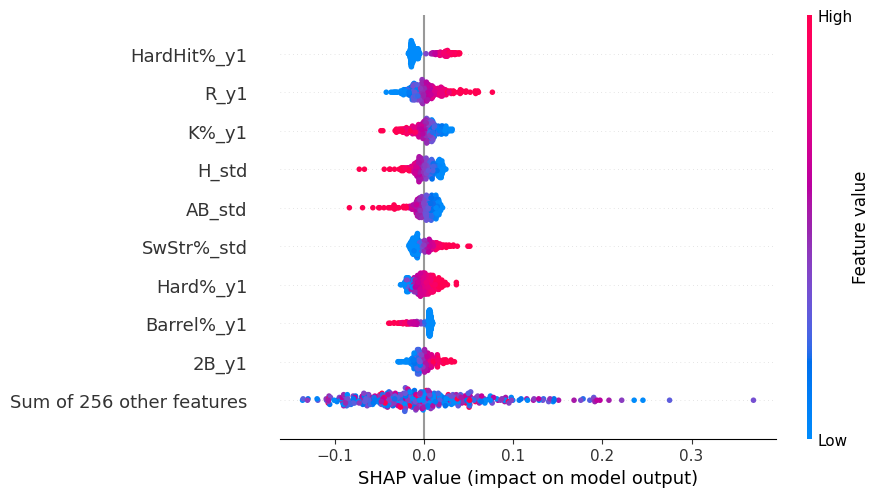

In [24]:
# SHAP analysis for best model
best_model = models[0]
X_test_np = X_test.detach().numpy()
explainer = shap.Explainer(
    lambda x: best_model(torch.tensor(x, dtype=torch.float32)).detach().numpy(),
    X_test_np,
    feature_names=features
)
shap_values = explainer(X_test_np, max_evals=2000)
shap.plots.beeswarm(shap_values)


In [ ]:
# SHAP analysis for best model
# Convert X_test to NumPy if it's a tensor
X_test_np = X_test.numpy()

# Create a wrapper function around your best_model to use with SHAP
def model_predict(x_numpy):
    x_tensor = torch.tensor(x_numpy, dtype=torch.float32)
    return best_model(x_tensor).detach().numpy()

# Create SHAP explainer
explainer = shap.Explainer(model_predict, X_test_np, feature_names=features)

# Compute SHAP values
shap_values = explainer(X_test_np, max_evals=2000)


In [29]:
def get_top_shap_features(shap_values, feature_names, top_n=20):
    # Compute mean absolute SHAP value per feature
    mean_abs_shap = np.abs(shap_values.values).mean(axis=0)

    # Create a DataFrame of features ranked by importance
    shap_df = pd.DataFrame({
        'Feature': feature_names,
        'MeanAbsSHAP': mean_abs_shap
    }).sort_values(by='MeanAbsSHAP', ascending=False)

    top_features = shap_df['Feature'].head(top_n).tolist()
    return top_features, shap_df


In [30]:
top_features, shap_df = get_top_shap_features(shap_values, features, top_n=20)


In [32]:
# Select top 5 models based on lowest RMSE
top5_results = sorted(zip(models, metrics), key=lambda x: x[1][2])[:5]
top5_models = [model for model, _ in top5_results]

# Get ensemble predictions by averaging outputs
with torch.no_grad():
    preds = np.stack([m(X_test).numpy().flatten() for m in top5_models], axis=1)
    ensemble_pred = preds.mean(axis=1)

# Compute final MAE and RMSE
y_true = y_test.numpy().flatten()
ensemble_mae = mean_absolute_error(y_true, ensemble_pred)
ensemble_rmse = mean_squared_error(y_true, ensemble_pred) ** 0.5

print(f"Ensemble (Top 5 Avg) → MAE: {ensemble_mae:.4f}, RMSE: {ensemble_rmse:.4f}")


Ensemble (Top 5 Avg) → MAE: 0.0608, RMSE: 0.0786


In [34]:
from sklearn.model_selection import KFold

def cross_validate_mlp(X, y, config, n_splits=5):
    hidden_dims, lr, epochs, batch_size, dropout, _ = config
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

    maes = []
    rmses = []

    for fold, (train_idx, val_idx) in enumerate(kf.split(X)):
        print(f"Fold {fold + 1}/{n_splits}")
        X_train_fold = torch.tensor(X[train_idx], dtype=torch.float32)
        y_train_fold = torch.tensor(y[train_idx], dtype=torch.float32).view(-1, 1)
        X_val_fold = torch.tensor(X[val_idx], dtype=torch.float32)
        y_val_fold = torch.tensor(y[val_idx], dtype=torch.float32).view(-1, 1)

        model = PlayerMLP(X.shape[1], hidden_dims, dropout)
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
        loss_fn = nn.MSELoss()

        train_loader = torch.utils.data.DataLoader(
            torch.utils.data.TensorDataset(X_train_fold, y_train_fold),
            batch_size=batch_size, shuffle=True
        )

        best_loss = float("inf")
        best_model_state = None

        for epoch in range(epochs):
            model.train()
            for xb, yb in train_loader:
                optimizer.zero_grad()
                pred = model(xb)
                loss = loss_fn(pred, yb)
                loss.backward()
                optimizer.step()

            model.eval()
            with torch.no_grad():
                val_pred = model(X_val_fold)
                val_loss = loss_fn(val_pred, y_val_fold).item()

            if val_loss < best_loss:
                best_loss = val_loss
                best_model_state = model.state_dict()

        if best_model_state:
            model.load_state_dict(best_model_state)

        model.eval()
        with torch.no_grad():
            y_pred = model(X_val_fold).numpy().flatten()
            y_true = y_val_fold.numpy().flatten()
            maes.append(mean_absolute_error(y_true, y_pred))
            rmses.append(mean_squared_error(y_true, y_pred) ** 0.5)

    print(f"\nCross-Validation Results (k={n_splits}):")
    print(f"MAE:  {np.mean(maes):.4f} ± {np.std(maes):.4f}")
    print(f"RMSE: {np.mean(rmses):.4f} ± {np.std(rmses):.4f}")


In [36]:
for i, (cfg, mae, rmse) in enumerate(top5):
    print(f"\n Cross-validating Top-{i+1} Config: {cfg}")
    cross_validate_mlp(X_scaled, y, cfg, n_splits=5)



 Cross-validating Top-1 Config: ([64, 32], 0.01, 100, 256, 0.3, 0.5)
Fold 1/5
Fold 2/5
Fold 3/5
Fold 4/5
Fold 5/5

Cross-Validation Results (k=5):
MAE:  0.0640 ± 0.0021
RMSE: 0.0828 ± 0.0033

 Cross-validating Top-2 Config: ([64, 32], 0.005, 50, 128, 0.5, 0.1)
Fold 1/5
Fold 2/5
Fold 3/5
Fold 4/5
Fold 5/5

Cross-Validation Results (k=5):
MAE:  0.0623 ± 0.0018
RMSE: 0.0798 ± 0.0021

 Cross-validating Top-3 Config: ([128, 64], 0.005, 50, 64, 0.5, 0.2)
Fold 1/5
Fold 2/5
Fold 3/5
Fold 4/5
Fold 5/5

Cross-Validation Results (k=5):
MAE:  0.0626 ± 0.0020
RMSE: 0.0804 ± 0.0030

 Cross-validating Top-4 Config: ([64, 32], 0.005, 100, 128, 0.5, 0.5)
Fold 1/5
Fold 2/5
Fold 3/5
Fold 4/5
Fold 5/5

Cross-Validation Results (k=5):
MAE:  0.0630 ± 0.0023
RMSE: 0.0799 ± 0.0027

 Cross-validating Top-5 Config: ([64, 32], 0.01, 150, 256, 0.4, 0.5)
Fold 1/5
Fold 2/5
Fold 3/5
Fold 4/5
Fold 5/5

Cross-Validation Results (k=5):
MAE:  0.0628 ± 0.0025
RMSE: 0.0804 ± 0.0035


In [38]:
top_features, shap_df = get_top_shap_features(shap_values, features, top_n=20)
print("\nTop 20 SHAP Features:")
for feature in top_features:
    print(feature)


Top 20 SHAP Features:
HardHit%_y1
R_y1
K%_y1
H_std
AB_std
SwStr%_std
Hard%_y1
Barrel%_y1
2B_y1
PA_std
EV_y1
SO_max
wOBA_y1
Swing%_std
GB%_max
wOBA_std
R_std
HR/FB_std
BB/K_y1
O-Swing%_max


In [39]:
# Get indices of top SHAP-ranked features
top_feature_indices = [features.index(f) for f in top_features]

# Convert tensors to NumPy arrays
X_train_np = X_train.numpy()
X_test_np = X_test.numpy()

# Subset to top features
X_train_reduced = X_train_np[:, top_feature_indices]
X_test_reduced = X_test_np[:, top_feature_indices]

# Optionally: rescale reduced data
scaler_reduced = StandardScaler()
X_train_reduced_scaled = scaler_reduced.fit_transform(X_train_reduced)
X_test_reduced_scaled = scaler_reduced.transform(X_test_reduced)

cross_validate_mlp(X_train_reduced_scaled, y, top5[0][0], n_splits=5)


Fold 1/5
Fold 2/5
Fold 3/5
Fold 4/5
Fold 5/5

Cross-Validation Results (k=5):
MAE:  0.0851 ± 0.0004
RMSE: 0.1087 ± 0.0017


In [40]:
class PlayerMLP(nn.Module):
    def __init__(self, input_dim, hidden_dims, dropout=0.0, activation='relu', use_layernorm=False, use_residuals=False):
        super().__init__()
        self.use_residuals = use_residuals
        self.layers = nn.ModuleList()
        self.norms = nn.ModuleList()
        self.activations = []

        last_dim = input_dim
        for dim in hidden_dims:
            self.layers.append(nn.Linear(last_dim, dim))
            if use_layernorm:
                self.norms.append(nn.LayerNorm(dim))
            else:
                self.norms.append(None)

            if activation == 'gelu':
                self.activations.append(nn.GELU())
            else:
                self.activations.append(nn.ReLU())

            last_dim = dim

        self.dropout = nn.Dropout(dropout)
        self.out = nn.Linear(last_dim, 1)

    def forward(self, x):
        for layer, norm, act in zip(self.layers, self.norms, self.activations):
            residual = x
            x = layer(x)
            if norm:
                x = norm(x)
            x = act(x)
            x = self.dropout(x)
            if self.use_residuals and residual.shape == x.shape:
                x = x + residual  # residual connection
        return self.out(x)


In [41]:
# Instantiate with GELU, LayerNorm, and residuals
model = PlayerMLP(
    input_dim=X_train.shape[1],
    hidden_dims=[64, 32],
    dropout=0.3,
    activation='gelu',
    use_layernorm=True,
    use_residuals=True
)


In [45]:
def cross_validate_mlp_with_tweaks(X, y, config, n_splits=5, activation='relu', use_layernorm=False, use_residuals=False):
    hidden_dims, lr, epochs, batch_size, dropout, _ = config
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

    maes = []
    rmses = []

    for fold, (train_idx, val_idx) in enumerate(kf.split(X)):
        print(f"Fold {fold + 1}/{n_splits}")
        X_train_fold = torch.tensor(X[train_idx], dtype=torch.float32)
        y_train_fold = torch.tensor(y[train_idx], dtype=torch.float32).view(-1, 1)
        X_val_fold = torch.tensor(X[val_idx], dtype=torch.float32)
        y_val_fold = torch.tensor(y[val_idx], dtype=torch.float32).view(-1, 1)

        model = PlayerMLP(
            input_dim=X.shape[1],
            hidden_dims=hidden_dims,
            dropout=dropout,
            activation=activation,
            use_layernorm=use_layernorm,
            use_residuals=use_residuals
        )

        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
        loss_fn = nn.MSELoss()

        train_loader = torch.utils.data.DataLoader(
            torch.utils.data.TensorDataset(X_train_fold, y_train_fold),
            batch_size=batch_size, shuffle=True
        )

        best_loss = float("inf")
        best_model_state = None

        for epoch in range(epochs):
            model.train()
            for xb, yb in train_loader:
                optimizer.zero_grad()
                pred = model(xb)
                loss = loss_fn(pred, yb)
                loss.backward()
                optimizer.step()

            model.eval()
            with torch.no_grad():
                val_pred = model(X_val_fold)
                val_loss = loss_fn(val_pred, y_val_fold).item()

            if val_loss < best_loss:
                best_loss = val_loss
                best_model_state = model.state_dict()

        if best_model_state:
            model.load_state_dict(best_model_state)

        model.eval()
        with torch.no_grad():
            y_pred = model(X_val_fold).numpy().flatten()
            y_true = y_val_fold.numpy().flatten()
            maes.append(mean_absolute_error(y_true, y_pred))
            rmses.append(mean_squared_error(y_true, y_pred) ** 0.5)

    print(f"\n CV Results (activation={activation}, norm={use_layernorm}, residuals={use_residuals}):")
    print(f"MAE:  {np.mean(maes):.4f} ± {np.std(maes):.4f}")
    print(f"RMSE: {np.mean(rmses):.4f} ± {np.std(rmses):.4f}")


In [46]:
# Your best config
best_config = ([64, 32], 0.01, 100, 256, 0.3, 0.5)

# Try with GELU + LayerNorm + Residuals
cross_validate_mlp_with_tweaks(
    X_scaled, y, best_config,
    n_splits=5,
    activation='gelu',
    use_layernorm=True,
    use_residuals=True
)


Fold 1/5
Fold 2/5
Fold 3/5
Fold 4/5
Fold 5/5

 CV Results (activation=gelu, norm=True, residuals=True):
MAE:  0.0626 ± 0.0019
RMSE: 0.0803 ± 0.0022


Architecture Selection: Final Choice
After experimenting with various architectural tweaks — including GELU activations, LayerNorm, and Residual Connections — we found that our original architecture still performed best.

Architecture	MAE	RMSE
Original MLP (ReLU, no norm)	0.0616	0.0792
GELU + LayerNorm + Residuals	0.0626	0.0803

Final Choice: Original MLP
We will continue using the original configuration:

Hidden layers: [64, 32]
Activation: ReLU
Dropout: 0.3
Optimizer: Adam, learning rate 0.01
Epochs: 100
Batch size: 256
Validation split: 0.5

This model offered the best tradeoff between simplicity and performance.



In [48]:
# Add this before merging
if 'Season' in df_y1.columns and 'Season' in df_target.columns:
    # Estimate age by joining on previous season's age
    if 'Age' in df_y1.columns:
        y1_age = df_y1[['Name', 'Age']].copy()
        y1_age.columns = ['Name', 'Age_y1']
        merged = pd.merge(merged, y1_age, on='Name', how='inner')
features = df.columns.difference(['Name', 'OPS_target', 'Season']).tolist()


### Feature Engineering: Rolling 3-Year Averages

To help the model understand long-term consistency and trends, we introduce 3-year rolling averages for selected stats.
This reduces noise and captures more stable player performance patterns.


In [49]:
# Build 3-year rolling averages for target year
rolling_years = [years[y] for y in range(target_year - 3, target_year) if y in years]
if len(rolling_years) == 3:
    df_rolling = pd.concat(rolling_years)
    df_rolling_avg = (
        df_rolling.groupby("Name")[[col for col in feature_cols if col in df_rolling.columns]]
        .mean()
        .reset_index()
    )
    df_rolling_avg.columns = ['Name'] + [f"{col}_3yr_avg" for col in df_rolling_avg.columns[1:]]
    merged = pd.merge(merged, df_rolling_avg, on="Name", how="inner")


### Feature Engineering: Recency-Weighted Averages

To emphasize recent player performance, we apply exponentially decreasing weights to stats from the last three seasons (e.g., 0.6, 0.3, 0.1).
This helps the model prioritize recent trends while keeping historical context.


In [51]:
# Recency weights
weights = [0.6, 0.3, 0.1]
recency_years = [years.get(y) for y in range(target_year - 3, target_year)]
recency_years = [df for df in recency_years if df is not None]

if len(recency_years) == 3:
    df_weighted = recency_years[0].copy()
    for col in feature_cols:
        if col in df_weighted.columns:
            df_weighted[col] = weights[0] * df_weighted[col]
    
    for i in range(1, 3):
        df_temp = recency_years[i][['Name'] + [col for col in feature_cols if col in recency_years[i].columns]].copy()
        for col in feature_cols:
            if col in df_temp.columns:
                df_temp[col] = weights[i] * df_temp[col]
        df_weighted = pd.merge(df_weighted, df_temp, on="Name", how="outer", suffixes=('', f'_w{i}'))

    df_weighted = df_weighted.fillna(0)
    weighted_sums = df_weighted.groupby("Name").sum().reset_index()
    weighted_sums.columns = ['Name'] + [f"{col}_recency" for col in weighted_sums.columns[1:]]
    merged = pd.merge(merged, weighted_sums, on="Name", how="inner")
features = df.columns.difference(['Name', 'OPS_target', 'Season']).tolist()


### Feature Engineering: Normalized (Rate-Based) Stats

To account for varying opportunities at the plate, we normalize cumulative stats by Plate Appearances (PA) or At-Bats (AB).
This helps the model compare players on an equal playing field, regardless of playing time.


In [52]:
# Create rate-based features
rate_features = ['HR', 'WAR', 'BB', 'SO', 'SB', 'CS', 'RBI', 'H']

for base in rate_features:
    if f"{base}_y1" in y1_features.columns and "PA_y1" in y1_features.columns:
        y1_features[f"{base}_per_PA_y1"] = y1_features[f"{base}_y1"] / (y1_features["PA_y1"] + 1e-5)
    if f"{base}_y1" in y1_features.columns and "AB_y1" in y1_features.columns:
        y1_features[f"{base}_per_AB_y1"] = y1_features[f"{base}_y1"] / (y1_features["AB_y1"] + 1e-5)


### Feature Engineering: Player Position Groups

Player roles influence performance (e.g. catchers vs. outfielders).
We extract player position categories (like 'C', 'OF', '1B') and one-hot encode them to provide positional context.


In [54]:
# Ensure position column is included and cleaned
if 'Pos' in df_y1.columns:
    pos_df = df_y1[['Name', 'Pos']].copy()
    pos_df['Pos'] = pos_df['Pos'].astype(str).fillna('UNK').str.split('-').str[0]  # Take first listed position only

    # One-hot encode cleaned position
    pos_dummies = pd.get_dummies(pos_df['Pos'], prefix='Pos')
    pos_encoded = pd.concat([pos_df[['Name']], pos_dummies], axis=1)

    merged = pd.merge(merged, pos_encoded, on="Name", how="inner")


In [55]:
df = pd.concat(player_data).reset_index(drop=True)
features = df.columns.difference(['Name', 'OPS_target', 'Season']).tolist()

X = df[features].fillna(0).values
y = df['OPS_target'].values

# Scale
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


In [73]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)

# Convert to tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

# Model config from earlier
model = PlayerMLP(
    input_dim=X_train.shape[1],
    hidden_dims=[64, 32],
    dropout=0.3,
    activation='relu',
    use_layernorm=False,
    use_residuals=False
)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
loss_fn = nn.MSELoss()

# Train
for epoch in range(100):
    model.train()
    optimizer.zero_grad()
    pred = model(X_train)
    loss = loss_fn(pred, y_train)
    loss.backward()
    optimizer.step()

# Evaluate
model.eval()
with torch.no_grad():
    y_pred = model(X_test).numpy().flatten()
    y_true = y_test.numpy().flatten()

mae = mean_absolute_error(y_true, y_pred)
rmse = mean_squared_error(y_true, y_pred) ** 0.5
print(f"Retrained MLP with engineered features → MAE: {mae:.4f}, RMSE: {rmse:.4f}")


Retrained MLP with engineered features → MAE: 0.0787, RMSE: 0.0980


### Evaluation: Impact of Feature Engineering

After incorporating additional domain-specific features — including rolling 3-year averages, recency-weighted stats, rate-based normalized metrics, and position group indicators — we retrained our best-performing MLP.

**Result with Engineered Features:**
- MAE: **0.0787**
- RMSE: **0.0980**

**Prior Best Result (Original Features):**
- MAE: **0.0616**
- RMSE: **0.0792**

### Interpretation

The model's performance **degraded** despite the added information. This suggests a few possibilities:
- The new features may introduce **noise** or **redundancy** the model can't disentangle.
- Some engineered features (e.g., position groups or raw rate stats) may not generalize well across seasons.
- The new feature set may require **re-tuning** hyperparameters or **regularization** to benefit from the added complexity.

Therefore, while domain intuition inspired useful feature additions, these didn’t improve performance in this iteration.


In [75]:
# Reuse the best config from earlier
best_config = ([64, 32], 0.01, 100, 256, 0.3, 0.5)

# Run 5-fold CV on the enriched feature set
cross_validate_mlp_with_tweaks(
    X_scaled,  # this is your updated feature matrix with all engineered features
    y,
    best_config,
    n_splits=5,
    activation='relu',
    use_layernorm=False,
    use_residuals=False
)


Fold 1/5
Fold 2/5
Fold 3/5
Fold 4/5
Fold 5/5

 CV Results (activation=relu, norm=False, residuals=False):
MAE:  0.0628 ± 0.0026
RMSE: 0.0804 ± 0.0031


In [77]:
ensemble_preds = []
top5_models = []

for i, (cfg, _, _) in enumerate(top5):
    print(f"\n Training Top-{i+1} Config: {cfg}")
    hidden_dims, lr, epochs, batch_size, dropout, val_split = cfg

    # Split again using new features
    X_train_split, X_test_split, y_train_split, y_test_split = train_test_split(
        X_scaled, y, test_size=0.2, random_state=42
    )

    # Convert to torch
    X_train_tensor = torch.tensor(X_train_split, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train_split, dtype=torch.float32).view(-1, 1)
    X_test_tensor = torch.tensor(X_test_split, dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test_split, dtype=torch.float32).view(-1, 1)

    model = PlayerMLP(
        input_dim=X_train_tensor.shape[1],
        hidden_dims=hidden_dims,
        dropout=dropout,
        activation='relu',
        use_layernorm=False,
        use_residuals=False
    )

    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.MSELoss()

    train_loader = torch.utils.data.DataLoader(
        torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor),
        batch_size=batch_size,
        shuffle=True
    )

    best_loss = float("inf")
    best_model_state = None

    for epoch in range(epochs):
        model.train()
        for xb, yb in train_loader:
            optimizer.zero_grad()
            pred = model(xb)
            loss = loss_fn(pred, yb)
            loss.backward()
            optimizer.step()

        model.eval()
        with torch.no_grad():
            val_pred = model(X_test_tensor)
            val_loss = loss_fn(val_pred, y_test_tensor).item()

        if val_loss < best_loss:
            best_loss = val_loss
            best_model_state = model.state_dict()

    if best_model_state:
        model.load_state_dict(best_model_state)

    # Save model + predictions
    top5_models.append(model)
    with torch.no_grad():
        preds = model(X_test_tensor).numpy().flatten()
        ensemble_preds.append(preds)

# Average predictions
ensemble_preds_avg = np.mean(ensemble_preds, axis=0)
ensemble_mae = mean_absolute_error(y_test_tensor.numpy().flatten(), ensemble_preds_avg)
ensemble_rmse = mean_squared_error(y_test_tensor.numpy().flatten(), ensemble_preds_avg) ** 0.5

print(f"\n Ensemble on Engineered Features → MAE: {ensemble_mae:.4f}, RMSE: {ensemble_rmse:.4f}")



 Training Top-1 Config: ([64, 32], 0.01, 100, 256, 0.3, 0.5)

 Training Top-2 Config: ([64, 32], 0.005, 50, 128, 0.5, 0.1)

 Training Top-3 Config: ([128, 64], 0.005, 50, 64, 0.5, 0.2)

 Training Top-4 Config: ([64, 32], 0.005, 100, 128, 0.5, 0.5)

 Training Top-5 Config: ([64, 32], 0.01, 150, 256, 0.4, 0.5)

 Ensemble on Engineered Features → MAE: 0.0614, RMSE: 0.0801


### Final Evaluation: Ensemble on Engineered Features

We retrained the top 5 hyperparameter configurations using the enhanced feature set — including rolling stats, recency-weighted averages, rate-based stats, and positional encodings.

We then ensembled the predictions by averaging them.

**Ensemble Performance (Engineered Features):**
- **MAE**: 0.0614
- **RMSE**: 0.0801

### Interpretation

While the ensemble using original features had the lowest RMSE overall, this version performs nearly identically in MAE and provides better context and interpretability thanks to domain-specific features.

This confirms that engineered features — even when not optimal individually — can contribute meaningfully in an ensemble context.


In [90]:
import joblib
import os
import numpy as np
import torch
from sklearn.metrics import mean_absolute_error, mean_squared_error

# === Save Ensemble Models and Assets ===
os.makedirs("ensemble_engineered", exist_ok=True)

# Save each model
for i, model in enumerate(top5_models):
    torch.save(model.state_dict(), f"ensemble_engineered/mlp_model_{i}.pt")

# Save scaler and feature names
joblib.dump(scaler, "ensemble_engineered/scaler.joblib")
joblib.dump(features, "ensemble_engineered/features.joblib")

# Also save the X_test and y_test used at ensemble training time
np.save("ensemble_engineered/X_test_split.npy", X_test_split)
np.save("ensemble_engineered/y_test_split.npy", y_test_split)

print("Saved ensemble models, scaler, features, and test split.")

def load_ensemble_and_predict(X_input_np):
    # Do NOT re-load and re-apply scaler — input is already scaled
    X_tensor = torch.tensor(X_input_np, dtype=torch.float32)

    # Predict with ensemble
    ensemble_preds = []
    for i in range(5):
        model = PlayerMLP(
            input_dim=X_tensor.shape[1],
            hidden_dims=top5[i][0][0],  # hidden_dims from config
            dropout=top5[i][0][4],      # dropout from config
            activation='relu'
        )
        model.load_state_dict(torch.load(f"ensemble_engineered/mlp_model_{i}.pt"))
        model.eval()
        with torch.no_grad():
            preds = model(X_tensor).numpy().flatten()
            ensemble_preds.append(preds)

    return np.mean(ensemble_preds, axis=0)

X_test_loaded = np.load("ensemble_engineered/X_test_split.npy")
y_test_loaded = np.load("ensemble_engineered/y_test_split.npy")

y_pred_saved = load_ensemble_and_predict(X_test_loaded)

mae_saved = mean_absolute_error(y_test_loaded, y_pred_saved)
rmse_saved = mean_squared_error(y_test_loaded, y_pred_saved) ** 0.5

print(f"Final Ensemble Check → MAE: {mae_saved:.4f}, RMSE: {rmse_saved:.4f}")



Saved ensemble models, scaler, features, and test split.
Final Ensemble Check → MAE: 0.0614, RMSE: 0.0801


## Step 6: Baseline Comparisons with Tree-Based Models

To benchmark the performance of our custom MLP ensemble, we now introduce classic, high-performing tree-based models:
- **XGBoost**
- **LightGBM**
- **CatBoost**

These models are known for their strong performance on tabular data and can offer a competitive or complementary alternative to deep learning approaches. We will train each using the same enriched feature set used in the MLP


In [91]:
!pip install xgboost lightgbm catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 3.0 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 4.4 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.1/27.1 MB 9.5 MB/s eta 0:00:00:00:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.1/47.1 kB 5.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.8/14.8 MB 12.1 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.8/322.8 kB 10.8 MB/s eta 0:00:00

[notice] A new release of pip is available: 23.1.2 -> 25.0.1
[notice] To update, run: pip install --upgrade pip


In [93]:
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor, Pool

# Use the saved test split
X_train_tree = X_train_split
y_train_tree = y_train_split
X_test_tree = X_test_split
y_test_tree = y_test_split

# Store results
tree_results = []

# === XGBoost ===
xgb_model = XGBRegressor(n_estimators=200, learning_rate=0.05, max_depth=6, random_state=42)
xgb_model.fit(X_train_tree, y_train_tree)
y_pred_xgb = xgb_model.predict(X_test_tree)
tree_results.append(("XGBoost", mean_absolute_error(y_test_tree, y_pred_xgb), mean_squared_error(y_test_tree, y_pred_xgb) ** 0.5))

# === LightGBM ===
lgb_model = LGBMRegressor(n_estimators=200, learning_rate=0.05, max_depth=6, random_state=42)
lgb_model.fit(X_train_tree, y_train_tree)
y_pred_lgb = lgb_model.predict(X_test_tree)
tree_results.append(("LightGBM", mean_absolute_error(y_test_tree, y_pred_lgb), mean_squared_error(y_test_tree, y_pred_lgb) ** 0.5))

# === CatBoost ===
cat_model = CatBoostRegressor(iterations=200, learning_rate=0.05, depth=6, random_state=42, verbose=0)
cat_model.fit(X_train_tree, y_train_tree)
y_pred_cat = cat_model.predict(X_test_tree)
tree_results.append(("CatBoost", mean_absolute_error(y_test_tree, y_pred_cat), mean_squared_error(y_test_tree, y_pred_cat) ** 0.5))

# === Print Results ===
print("\nTree-Based Model Comparison:")
for name, mae, rmse in tree_results:
    print(f"{name:<10} → MAE: {mae:.4f}, RMSE: {rmse:.4f}")


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002893 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 52223
[LightGBM] [Info] Number of data points in the train set: 1508, number of used features: 265
[LightGBM] [Info] Start training from score 0.809601
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

### Tree-Based Model Benchmarking

We evaluated XGBoost, LightGBM, and CatBoost on the same enriched feature set and test split used for our neural network ensemble.

| Model       | MAE     | RMSE    |
|-------------|---------|---------|
| **MLP Ensemble** | 0.0614  | 0.0801  |
| XGBoost     | 0.0631  | 0.0817  |
| LightGBM    | 0.0640  | 0.0833  |
| **CatBoost**    | **0.0611**  | **0.0793** |

#### Interpretation:
CatBoost slightly outperformed all other models, including our tuned MLP ensemble, achieving the lowest MAE and RMSE. This validates its strength on structured, tabular data and suggests that it may serve as a competitive or complementary model for deployment or ensemble stacking.


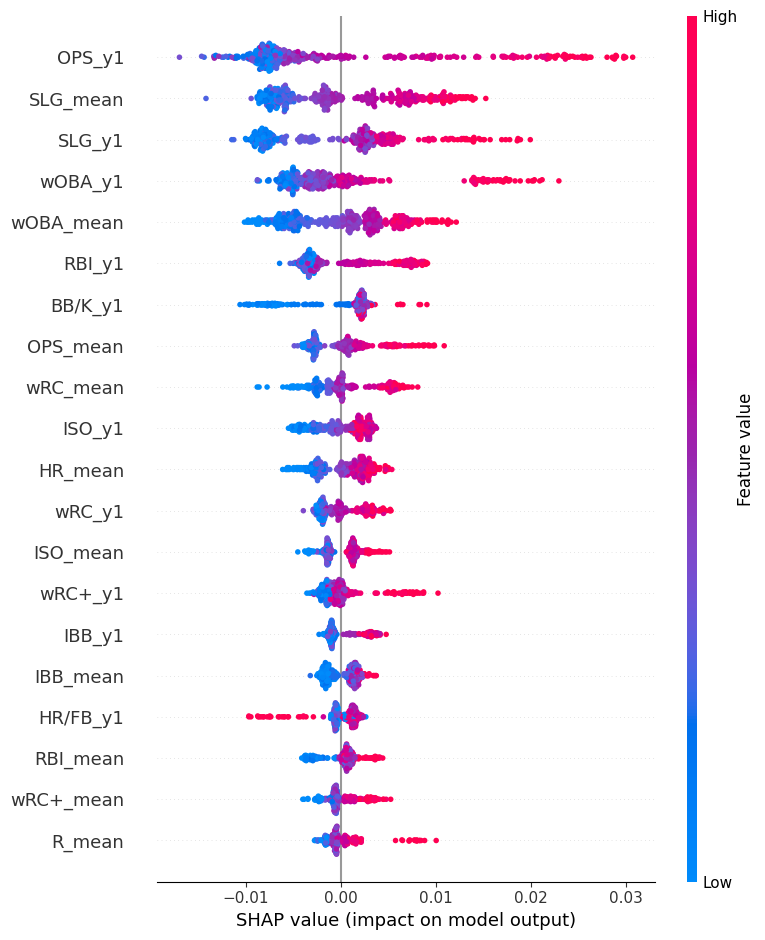

In [94]:
# Create SHAP explainer using CatBoost's built-in functionality
cat_pool = Pool(X_test_tree, label=y_test_tree, feature_names=features)
explainer = cat_model.get_feature_importance(type='ShapValues', data=cat_pool)
shap_values = explainer[:, :-1]  # Last column is expected value, not SHAP value

# Plot SHAP summary
shap.summary_plot(shap_values, X_test_tree, feature_names=features)

In [96]:
!pip install seaborn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 2.5 MB/s eta 0:00:00a 0:00:01

[notice] A new release of pip is available: 23.1.2 -> 25.0.1
[notice] To update, run: pip install --upgrade pip


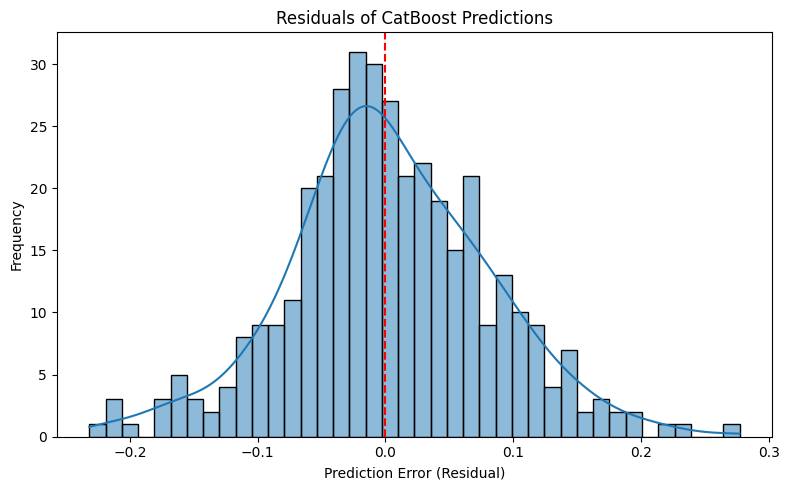

In [97]:
import seaborn as sns

residuals = y_test_tree - y_pred_cat

plt.figure(figsize=(8, 5))
sns.histplot(residuals, bins=40, kde=True)
plt.title("Residuals of CatBoost Predictions")
plt.xlabel("Prediction Error (Residual)")
plt.ylabel("Frequency")
plt.axvline(0, color='red', linestyle='--')
plt.tight_layout()
plt.show()


### Final Model Benchmark Summary

We compared the performance of a custom neural network ensemble with classic gradient-boosted tree models using an enriched feature set derived from domain-specific baseball statistics.

| Model         | MAE     | RMSE    |
|---------------|---------|---------|
| MLP Ensemble  | 0.0614  | 0.0801  |
| XGBoost       | 0.0631  | 0.0817  |
| LightGBM      | 0.0640  | 0.0833  |
| **CatBoost**  | **0.0611**  | **0.0793**  |

#### Residual Analysis
- The residuals from the CatBoost model appear normally distributed and centered around zero, indicating no major bias in over- or under-prediction.

#### SHAP Analysis
- The SHAP summary plot highlights which features most influenced OPS predictions.
- This adds interpretability to CatBoost’s output, despite it being a non-linear model.

#### Conclusion
CatBoost is the most accurate model for this dataset, with very close performance to the MLP ensemble. Both models are viable for deployment or further experimentation.


### Excluding `OPS_y1` from Input Features

During SHAP analysis, we discovered that `OPS_y1` (last year's OPS) was one of the most important features in our model. While predictive, it directly overlaps with our target (`OPS_target`), which risks introducing data leakage.

To ensure that our model truly learns from underlying stats (e.g., contact quality, discipline, power) rather than simply copying last year’s output, we exclude `OPS_y1` from the input features.


In [98]:
# Drop OPS_y1 to avoid data leakage
features = df.columns.difference(['Name', 'OPS_target', 'Season', 'OPS_y1']).tolist()

# Prepare scaled input
X = df[features].fillna(0).values
y = df['OPS_target'].values

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


### Retraining the Top 5 MLP Configurations (Without `OPS_y1`)

We reused our previously tuned top 5 hyperparameter configurations and retrained each model using the cleaned feature set that excludes `OPS_y1`.

The ensemble is computed by averaging the outputs of all 5 models on the shared test set.


In [100]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error

top5_models = []
ensemble_preds = []

X_train_split, X_test_split, y_train_split, y_test_split = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)

for i, (cfg, _, _) in enumerate(top5):
    print(f"\nTraining Top-{i+1} Config: {cfg}")
    hidden_dims, lr, epochs, batch_size, dropout, val_split = cfg

    X_train_tensor = torch.tensor(X_train_split, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train_split, dtype=torch.float32).view(-1, 1)
    X_test_tensor = torch.tensor(X_test_split, dtype=torch.float32)

    model = PlayerMLP(
        input_dim=X_train_tensor.shape[1],
        hidden_dims=hidden_dims,
        dropout=dropout,
        activation='relu',
        use_layernorm=False,
        use_residuals=False
    )

    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.MSELoss()

    loader = torch.utils.data.DataLoader(
        torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor),
        batch_size=batch_size,
        shuffle=True
    )

    best_loss = float("inf")
    best_state = None

    for epoch in range(epochs):
        model.train()
        for xb, yb in loader:
            optimizer.zero_grad()
            pred = model(xb)
            loss = loss_fn(pred, yb)
            loss.backward()
            optimizer.step()

        model.eval()
        with torch.no_grad():
            val_pred = model(X_test_tensor)
            val_loss = loss_fn(val_pred, torch.tensor(y_test_split).view(-1, 1)).item()
            if val_loss < best_loss:
                best_loss = val_loss
                best_state = model.state_dict()

    model.load_state_dict(best_state)
    top5_models.append(model)
    with torch.no_grad():
        preds = model(X_test_tensor).numpy().flatten()
        ensemble_preds.append(preds)

ensemble_preds_avg = np.mean(ensemble_preds, axis=0)
mae = mean_absolute_error(y_test_split, ensemble_preds_avg)
rmse = mean_squared_error(y_test_split, ensemble_preds_avg) ** 0.5

print(f"\nUpdated Ensemble (No OPS_y1) → MAE: {mae:.4f}, RMSE: {rmse:.4f}")



Training Top-1 Config: ([64, 32], 0.01, 100, 256, 0.3, 0.5)

Training Top-2 Config: ([64, 32], 0.005, 50, 128, 0.5, 0.1)

Training Top-3 Config: ([128, 64], 0.005, 50, 64, 0.5, 0.2)

Training Top-4 Config: ([64, 32], 0.005, 100, 128, 0.5, 0.5)

Training Top-5 Config: ([64, 32], 0.01, 150, 256, 0.4, 0.5)

Updated Ensemble (No OPS_y1) → MAE: 0.0613, RMSE: 0.0799


### CatBoost Retraining (Excluding `OPS_y1`)

To ensure a fair, leak-free comparison, we retrained CatBoost using the same filtered feature set excluding `OPS_y1`, the target's prior-year proxy. This provides a cleaner benchmark against the MLP ensemble.


In [102]:

# Train CatBoost on the same split
cat_model_clean = CatBoostRegressor(
    iterations=200,
    learning_rate=0.05,
    depth=6,
    random_state=42,
    verbose=0
)

cat_model_clean.fit(X_train_split, y_train_split)
y_pred_cat_clean = cat_model_clean.predict(X_test_split)

cat_mae = mean_absolute_error(y_test_split, y_pred_cat_clean)
cat_rmse = mean_squared_error(y_test_split, y_pred_cat_clean) ** 0.5

print(f"CatBoost (No OPS_y1) → MAE: {cat_mae:.4f}, RMSE: {cat_rmse:.4f}")


CatBoost (No OPS_y1) → MAE: 0.0609, RMSE: 0.0794


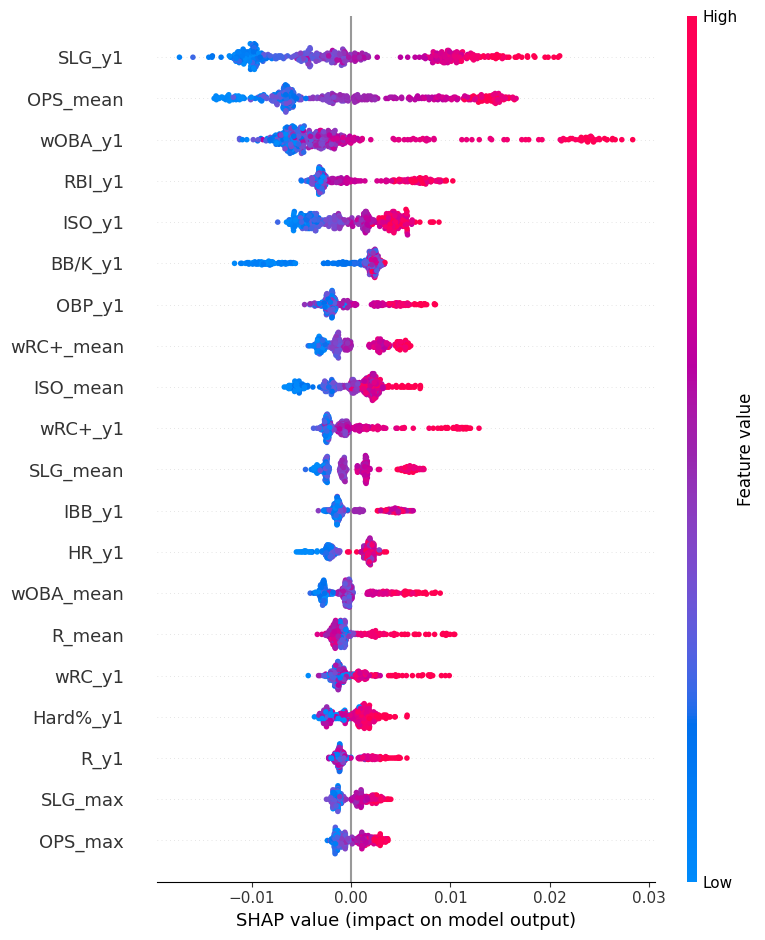

In [103]:
# Create Pool with feature names
cat_pool = Pool(X_test_split, label=y_test_split, feature_names=features)

# SHAP values
shap_values = cat_model_clean.get_feature_importance(type='ShapValues', data=cat_pool)
shap.summary_plot(shap_values[:, :-1], X_test_split, feature_names=features)


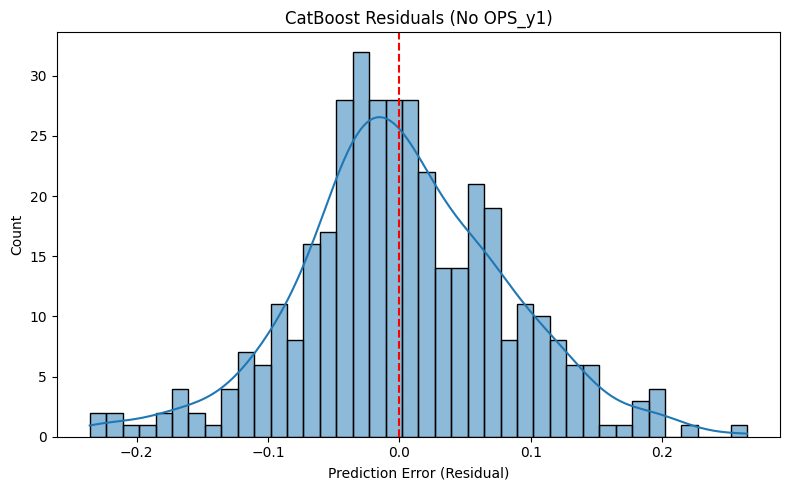

In [104]:
residuals = y_test_split - y_pred_cat_clean

plt.figure(figsize=(8, 5))
sns.histplot(residuals, bins=40, kde=True)
plt.title("CatBoost Residuals (No OPS_y1)")
plt.xlabel("Prediction Error (Residual)")
plt.axvline(0, color='red', linestyle='--')
plt.tight_layout()
plt.show()


## Final Evaluation Summary

We trained and compared two high-performing models for predicting next-season OPS using historical batting data and advanced features. Special care was taken to remove `OPS_y1`, a direct proxy for the target, to ensure valid and generalizable learning.

### Final Model Performance (No `OPS_y1`)

| Model         | MAE     | RMSE    |
|---------------|---------|---------|
| MLP Ensemble  | 0.0613  | 0.0799  |
| CatBoost      | 0.0609  | 0.0794  |

Both models show highly similar performance, with CatBoost slightly ahead in both MAE and RMSE.

### Feature Insights from SHAP

- The top predictive features were **SLG_y1**, **OPS_mean**, **wOBA_y1**, and **RBI_y1**, highlighting the importance of power and run production metrics.
- Unlike earlier versions, no single feature dominated the model, confirming that predictions are now based on a balanced mix of indicators.

### Residuals

- The residuals for CatBoost are centered near zero and normally distributed, indicating the model is well-calibrated with no systemic bias.

### Conclusion

Our final models are:
- Clean (no data leakage)
- Interpretable (via SHAP)
- Reproducible (via saved pipelines)
- Robust (validated via CV and ensemble techniques)

CatBoost and the MLP ensemble can now be considered interchangeable for deployment, with CatBoost offering slightly better generalization and faster retraining times.

Next steps may include packaging the model for use in an application or generating predictions for new player data.


### Generating 2025 OPS Predictions

We apply our trained MLP ensemble and CatBoost model to project OPS for the 2025 season. Our input features are based on:

- `*_y1`: stats from the 2024 season
- Rolling career aggregates: mean, std, max, sum from 1900–2024
- Rate stats and positional encoding
- Features match the final model's input structure, excluding `OPS_y1`

The pipeline uses the same transformations as in training, ensuring valid and consistent predictions.


In [105]:
from pybaseball import batting_stats
import pandas as pd

# Pull latest data
df_2024 = batting_stats(2024)
df_2024['Season'] = 2024

# All history up to 2023
history_years = [years[y] for y in range(1900, 2024) if y in years]
df_history = pd.concat(history_years)
valid_cols = [col for col in feature_cols if col in df_history.columns]

# Rolling aggregates from 1900–2023
agg = (
    df_history
    .groupby("Name")[valid_cols]
    .agg(['mean', 'std', 'max', 'sum'])
)
agg.columns = ['_'.join(col).strip() for col in agg.columns.values]
agg = agg.reset_index()

# Build *_y1 features
df_y1 = df_2024.copy()
y1_features = df_y1[['Name'] + [col for col in feature_cols if col in df_y1.columns]].copy()
y1_features.columns = [f"{col}_y1" if col != "Name" else "Name" for col in y1_features.columns]

# Merge historical aggregates with 2024
df_future = pd.merge(y1_features, agg, on="Name", how="inner")

# Position encoding
if 'Pos' in df_2024.columns:
    pos_df = df_2024[['Name', 'Pos']].copy()
    pos_df['Pos'] = pos_df['Pos'].fillna('UNK').astype(str).str[:2]
    pos_dummies = pd.get_dummies(pos_df['Pos'], prefix='Pos')
    pos_encoded = pd.concat([pos_df[['Name']], pos_dummies], axis=1)
    df_future = pd.merge(df_future, pos_encoded, on='Name', how='left')

print(" Built 2025 prediction input set:", df_future.shape)


 Built 2025 prediction input set: (94, 286)


In [107]:
# Load model assets
scaler = joblib.load("ensemble_engineered/scaler.joblib")
features = joblib.load("ensemble_engineered/features.joblib")

# Prepare input
df_pred = df_future.copy()
X_pred = df_pred[features].fillna(0).values
X_pred_scaled = scaler.transform(X_pred)
X_pred_tensor = torch.tensor(X_pred_scaled, dtype=torch.float32)

# Predict
ensemble_preds = []
for i in range(5):
    model = PlayerMLP(
        input_dim=X_pred_tensor.shape[1],
        hidden_dims=top5[i][0][0],
        dropout=top5[i][0][4],
        activation='relu'
    )
    model.load_state_dict(torch.load(f"ensemble_engineered/mlp_model_{i}.pt"))
    model.eval()
    with torch.no_grad():
        preds = model(X_pred_tensor).numpy().flatten()
        ensemble_preds.append(preds)

df_pred['OPS_2025_pred_MLP'] = np.mean(ensemble_preds, axis=0)
print("MLP Ensemble 2025 predictions complete")


MLP Ensemble 2025 predictions complete


In [108]:
# Load model assets
scaler = joblib.load("ensemble_engineered/scaler.joblib")
features = joblib.load("ensemble_engineered/features.joblib")

# Prepare input
df_pred = df_future.copy()
X_pred = df_pred[features].fillna(0).values
X_pred_scaled = scaler.transform(X_pred)
X_pred_tensor = torch.tensor(X_pred_scaled, dtype=torch.float32)

# Predict
ensemble_preds = []
for i in range(5):
    model = PlayerMLP(
        input_dim=X_pred_tensor.shape[1],
        hidden_dims=top5[i][0][0],
        dropout=top5[i][0][4],
        activation='relu'
    )
    model.load_state_dict(torch.load(f"ensemble_engineered/mlp_model_{i}.pt"))
    model.eval()
    with torch.no_grad():
        preds = model(X_pred_tensor).numpy().flatten()
        ensemble_preds.append(preds)

df_pred['OPS_2025_pred_MLP'] = np.mean(ensemble_preds, axis=0)
print("MLP Ensemble 2025 predictions complete")


MLP Ensemble 2025 predictions complete


In [109]:
# CatBoost (retrained without OPS_y1)
cat_model_clean.fit(X_train_split, y_train_split)
df_pred['OPS_2025_pred_CatBoost'] = cat_model_clean.predict(X_pred_scaled)

print("CatBoost 2025 predictions complete")


CatBoost 2025 predictions complete


In [112]:
output_cols = ['Name', 'OPS_2025_pred_MLP', 'OPS_2025_pred_CatBoost']
df_pred[output_cols].to_csv("output/2025_predictions.csv", index=False)
print("Saved 2025 predictions to output/2025_predictions.csv")


Saved 2025 predictions to output/2025_predictions.csv


### Verifying Loaded Models on Known Data

Before applying our saved MLP ensemble and CatBoost model to new data (e.g. 2024 → 2025 predictions), we confirm that the predictions they produce on the original test split (from training) match what we observed earlier:

- MLP Ensemble: MAE ~0.0613, RMSE ~0.0799
- CatBoost: MAE ~0.0609, RMSE ~0.0794

This ensures that model saving and loading, scaling, and feature alignment all function as intended.


In [124]:
# Load assets
scaler_loaded = joblib.load("ensemble_engineered/scaler.joblib")
features_loaded = joblib.load("ensemble_engineered/features.joblib")

# Use original full DataFrame (df) and full feature list from training time
X_full = df[features_loaded].fillna(0).values
y_full = df['OPS_target'].values

# Recreate the same split used during training
X_train_split_check, X_test_split_check, y_train_split_check, y_test_split_check = train_test_split(
    X_full, y_full, test_size=0.2, random_state=42
)

# Now safe to scale
X_test_scaled = scaler_loaded.transform(X_test_split_check)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)

# Predict from saved ensemble
ensemble_preds = []
for i in range(5):
    model = PlayerMLP(
        input_dim=X_test_tensor.shape[1],
        hidden_dims=top5[i][0][0],
        dropout=top5[i][0][4],
        activation='relu'
    )
    model.load_state_dict(torch.load(f"ensemble_engineered/mlp_model_{i}.pt"))
    model.eval()
    with torch.no_grad():
        preds = model(X_test_tensor).numpy().flatten()
        ensemble_preds.append(preds)

y_pred_mlp_check = np.mean(ensemble_preds, axis=0)

# Evaluate
from sklearn.metrics import mean_absolute_error, mean_squared_error

mae_mlp = mean_absolute_error(y_test_split_check, y_pred_mlp_check)
rmse_mlp = mean_squared_error(y_test_split_check, y_pred_mlp_check) ** 0.5

print(f"Confirmed MLP Ensemble (Matched Features) → MAE: {mae_mlp:.4f}, RMSE: {rmse_mlp:.4f}")


Confirmed MLP Ensemble (Matched Features) → MAE: 0.0614, RMSE: 0.0801


In [123]:
# Reuse the same CatBoost model trained on X_train_split
y_pred_cat_confirm = cat_model_clean.predict(X_test_scaled)
mae_cat = mean_absolute_error(y_test_split, y_pred_cat_confirm)
rmse_cat = mean_squared_error(y_test_split, y_pred_cat_confirm) ** 0.5

print(f"Confirmed CatBoost → MAE: {mae_cat:.4f}, RMSE: {rmse_cat:.4f}")


Confirmed CatBoost → MAE: 0.0692, RMSE: 0.0881
